Primero importamos las librerías necesarias

In [10]:
import pandas as pd
import numpy as np
import os
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import xgboost as xgb
os.chdir('/Users/samirchar/Google Drive/Data Science/Proyectos data science/Facturedo/')

Se cargan los datos

In [11]:
df=pd.read_excel('test_data_set.xlsx')

Ahora aquí creo una clase para poder codificar todas las variables categóricas y realizar label encoding. Esta clase permite crear diccionarios con las transformaciones para siempre poder pasar de las variables categóricas a su forma codificada y viceversa

In [12]:
class label_encoder():    
    def dictionaries(X,cols):#Función que crea el diccionario en base a los datos
        from collections import namedtuple
        from sklearn.preprocessing import LabelEncoder
        transform_dict={}#AquÌ se guardar· el diccionario para transformar
        inverse_transform_dict={}#AquÌ se guardar· el diccionario para transformada inversa
        
        for i in cols:#For que realiza el fit sobre las columnas indicadas
            le=LabelEncoder()
            le.fit(X[i])
            transform_dict[i]=dict(zip(le.classes_, le.transform(le.classes_)))#Crea diccionario de para transformar a partir de LabelEncoder
            inverse_transform_dict[i]=dict(zip(le.transform(le.classes_),le.classes_))#Crea diccionario de para transfoda inversa a partir de LabelEncoder
        dictionary_tuple = namedtuple('dictionary_tuple', ['transform_dict', 'inverse_transform_dict'])#Crea instancia de namedtuple
        transformation_dictionaries=dictionary_tuple(transform_dict,inverse_transform_dict)#Guarda diccionarios como namedtuple
        return(transformation_dictionaries)

    def transform(X,transform_dictionary):#FunciÛn que transforma datos en base a un diccionario. Este diccionario se crea con funciÛn "dictionaries"
        X_encoded=X.replace(transform_dictionary,inplace=True)#Reemplaza los factores de las variables categÛricas a n˙meros de acuerdo al diccionario.
        return()

    def inverse_transform(X,inverse_transform_dictionary):#FunciÛn que realiza transformada inversa de datos en base a un diccionario. Este diccionario se crea con funciÛn "dictionaries"
        X_decoded=X.replace(inverse_transform_dictionary,inplace=True)#Reemplaza los n˙meros de las variables categÛricas de acuerdo al diccionario.
        return()

Creamos la matriz de características 'X' y la variable objetivo 'y'

In [13]:
X=df.iloc[:,0:-1]
y=df.iloc[:,-1].copy()

Ahora seleccionamos las variables categóricas y las codificamos usando la clase creada con anterioridad.

In [14]:
categoric_variables=X.select_dtypes('object').columns.tolist()
dictionaries=label_encoder.dictionaries(X,categoric_variables)
label_encoder.transform(X,dictionaries.transform_dict)


()

Aquí vemos uno de los uso de la clase previamente creada. Si miramos dictionaries.transform_dict veremos un diccionario de diccionarios donde se ven todas las codificaciones. Esta clase tambien tiene otras funciones que no  

In [89]:
dictionaries.transform_dict

{'payment_method': {"'cheque'": 0, "'transferencia bancaria'": 1},
 'mean_time': {'120 días': 0, '30 días': 1, '60 días': 2, '90 días': 3},
 'invoice_mean_val': {'Entre USD 1000 y USD 5000': 0,
  'Entre USD 20000 y USD 100000': 1,
  'Entre USD 5000 y USD 20000': 2,
  'Menos de USD 1000': 3,
  'Más de USD 100000': 4},
 'entity_type': {'persona jurídica': 0, 'persona natural': 1}}

Ahora creamos una nueva variable basada en payment y creation date que será la resta de estas dos. Esto nos dará el número de días que hay entre la fecha que se crea la operación en la plataforma y la fecha del pago. Luego eliminamos la fecha de pago y la fecha de creación y nos quedamos solo con la nueva variable que se llamará 'days_until_payment'


In [15]:
days_until_payment=(X['payment_date']-X['creation_date']).dt.days
X=X.assign(days_until_payment=days_until_payment)
del(X['creation_date'],X['payment_date'],X['operation_id'])#Eliminamos 

Los datos después de todas las transformaciones se ven de la siguiente manera

In [91]:
X.head()

,amount,payment_method,anual_sales_volume,mean_time,invoice_mean_val,entity_type,relationship_years,city,industry,days_until_payment
0,18714.00,0,391000,3,2,1,5,20,9,72
1,1596.00,0,33000,2,3,0,7,11,12,42
2,19152.00,0,409000,1,1,1,1,12,10,101
3,6354.00,0,68000,3,2,0,8,17,5,116
4,9729.72,0,214000,0,1,1,3,7,15,119


## Desarrollo y evaluación de algoritmos

Se usa validación cruzada de 10 iteraciones para medir el desempeño de los algoritmos. Se hizo de esta manera ya que solo hay 300 observaciones y dividir los datos en entrenamiento y prueba no resulta una buena idea. La métrica definida para medir desempeño es exactitud (accuracy en inglés)

Primero entrenamos un Random Forest. Después de la sintonización de los hiperparámetros el resultado final es el siguiente

In [120]:
rf=RandomForestClassifier(n_estimators=100,max_features=3,random_state=44)

cv=cross_val_score(rf,X,y,cv=10,scoring='accuracy')
print('Random Forest accuracy is: ',cv.mean()*100)

Random Forest accuracy is:  60.515387467556536


La importancia de las variables para determinar si una operación es aceptada o rechazada se muestra en el siguiente bloque

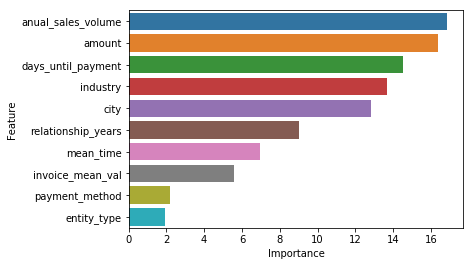

In [121]:
rf.fit(X,y)
importances=pd.DataFrame(data={'Feature':X.columns,'Importance':rf.feature_importances_*100})
importances.sort_values(by='Importance',inplace=True,ascending=False)
sb.barplot(x='Importance',y='Feature',data=importances,orient='h')
plt.show()

Ahora bien, entrenamos un algoritmo de xgboost, que es un modelo más avanzado que el anterior. Después de sintonizar los hiperparámetros el resultado final es el siguiente

In [123]:
params={'max_depth':4,
       'eta':0.01,
        'min_child_weight':5,
       'objective':'binary:logistic'}
dtrain=xgb.DMatrix(data=X,label=(y=='Aceptada')*1)
cv=xgb.cv(params=params,nfold=10,dtrain=dtrain,num_boost_round=1000,early_stopping_rounds=50)
print('xgboost accuracy is : ',(1-cv['test-error-mean'].min())*100)

xgb_model=xgb.train(params=params,num_boost_round=75,dtrain=dtrain)

xgboost accuracy is :  61.16092


En conlusión, se entrenaron 2 algoritmos diferentes para ver cuál tenía el mejor desempeño. El algoritmo ganador fue xgboost con una exactitud (accuracy) de 61.16%. Este algoritmo queda guardado en la variable 'xgb_model'. El algoritmo de random forest queda guardado en la vriable 'rf'